[View in Colaboratory](https://colab.research.google.com/github/brucecmd/learn_gluon/blob/master/under_fitting_and_over_fitting3.ipynb)

In [0]:
import matplotlib.pyplot as plt

In [0]:
# Firstly, define a function to draw error loss picture
def draw(train_loss, test_loss):
    # draw the error curve
    plt.xlabel('epoch')
    plt.ylabel('Error')
    plt.plot(train_loss, c='r',label='train_loss')
    plt.plot(test_loss, c='b', label='test_loss')
    plt.legend()
    plt.show()

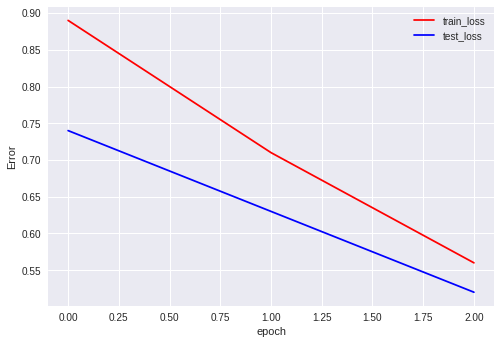

In [235]:
# test draw function
draw([0.89, 0.71, 0.56], [0.74, 0.63, 0.52])

In [0]:
from mxnet import nd, autograd
from mxnet.gluon import data as gdata

In [237]:
# begin make data
tmp_x = nd.random_normal(0,1,shape=(1000,1)) # shape must be (1000,1) instead of (1000,), or nd.power will fail
x = nd.concat(tmp_x, nd.power(tmp_x,2), nd.power(tmp_x,3))
true_w = [3.8, -2,7, 1.3]
true_b = 9.2
y = true_w[0] * x[:,0] + true_w[1] * x[:,1] + true_w[2] * x[:,2] + true_b
y += nd.random_normal(0,0.01,shape=y.shape)
print(x[:,:3])


[[-0.92416906  0.8540885  -0.78932214]
 [-1.3193825   1.7407703  -2.296742  ]
 [ 0.7229788   0.5226983   0.37789977]
 ...
 [-0.22140698  0.04902105 -0.0108536 ]
 [-0.3010883   0.09065416 -0.02729491]
 [-1.4131563   1.9970106  -2.822088  ]]
<NDArray 1000x3 @cpu(0)>


In [238]:
# prepare data_iter
def get_data_iter(x,y,train_ratio, batch_size):
    # split train and test by train_ratio
    train_len = int(len(x) * train_ratio)
    test_len = len(x) - train_len
    train_dataset = gdata.ArrayDataset(x[:train_len,:],y[:train_len])  # the dataset has not shape, so split data first, not in Dataloader function
    test_dataset = gdata.ArrayDataset(x[train_len:,:],y[train_len:])
    train_iter = gdata.DataLoader(train_dataset, batch_size, shuffle=True)
    test_iter = gdata.DataLoader(test_dataset, batch_size, shuffle=True)
    return train_iter, test_iter
train_iter, test_iter = get_data_iter(x,y,0.8,10)
for data,label in train_iter:
    print(data)
    print(label)
    break


[[ 1.2484678e-01  1.5586718e-02  1.9459516e-03]
 [-3.6479577e-01  1.3307595e-01 -4.8545547e-02]
 [-5.0198309e-02  2.5198702e-03 -1.2649322e-04]
 [-2.3786969e+00  5.6581988e+00 -1.3459141e+01]
 [-1.9567144e+00  3.8287313e+00 -7.4917336e+00]
 [-4.7478697e-01  2.2542267e-01 -1.0702774e-01]
 [-6.9433230e-01  4.8209736e-01 -3.3473575e-01]
 [-8.7274814e-01  7.6168931e-01 -6.6476291e-01]
 [-2.1787506e-01  4.7469541e-02 -1.0342429e-02]
 [ 1.2631835e+00  1.5956324e+00  2.0155766e+00]]
<NDArray 10x3 @cpu(0)>

[   9.681624      7.208869      9.003659   -105.39361     -58.346046
    6.193571      3.2486234    -0.29733145    8.197852     24.933622  ]
<NDArray 10 @cpu(0)>


In [0]:
# define net
from mxnet.gluon import nn
from mxnet import init
net = nn.Sequential()
net.add(nn.Flatten())
net.add(nn.Dense(1))
net.initialize(init.Normal(sigma=0.01))

In [0]:
# prepare loss function
from mxnet.gluon import loss as gloss
loss_func = gloss.L2Loss()

In [0]:
# prepare trainer
from mxnet import gluon
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate':0.01})

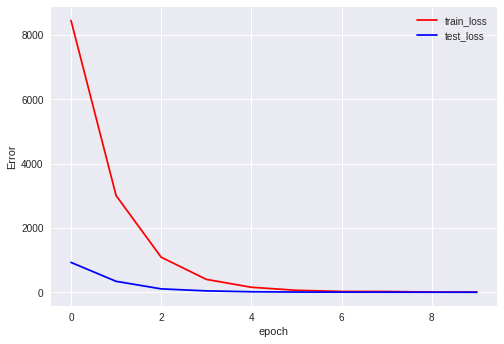

In [242]:
# because it is regression, use loss(from loss function) instead of accuracy function
# begin train and test
epochs = 10
batch_size = 10
train_len = int(len(x) * 0.9)
train_iter, test_iter = get_data_iter(x,y,0.9,batch_size)
train_loss_list = []
test_loss_list = []
for i in range(epochs):
    for data, label in train_iter:
        with autograd.record():
            y_hat = net(data)
            l = loss_func(y_hat, label)
        l.backward()
        trainer.step(batch_size)
    train_loss = loss_func(net(x[:train_len,:]), y[:train_len]).sum().asscalar()
    test_loss = loss_func(net(x[train_len:,:]), y[train_len:]).sum().asscalar()
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)
draw(train_loss_list, test_loss_list)    
    